## Imports y definición de las variables de archivos
---

In [34]:
import re #Regex
import os #Access files

import nltk #Tokenization
nltk.download('punkt') #Tokenization

import numpy as np #Confusion matrix
import seaborn as sns #Confusion matrix
import matplotlib.pyplot as plt #Confusion matrix
import sklearn #Confusion matrix

train_files_list = [f for f in os.listdir('corpora') if re.search(r'_trn\.txt$', f)]
test_files_list = [f for f in os.listdir('corpora') if re.search(r'_tst\.txt$', f)]

print(train_files_list)



['deu_trn.txt', 'eng_trn.txt', 'fra_trn.txt', 'ita_trn.txt', 'nld_trn.txt', 'spa_trn.txt']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing
---

· Eliminar digitos del texto
· Convertir todo el texto a minúsculas
· Eliminar caracteres especiales
· Sustituir los espacios en blanco continuos por uno solo
· Concatenar todas las frases con un espacio doble en el medio


In [35]:

def preprocessing(text):
    
    text = re.sub(r'[^\w\s]', '', text) # Elimina signos de puntuación
    text = re.sub(r'\d+', '', text) # Elimina números
    text = text.lower() # Convierte a minúsculas
    text = re.sub(r'[\s\n]+', ' ', text) # Elimina espacios en blanco sobrantes excepto \n
    text = re.sub(r' +', ' ', text) # Elimina espacios en blanco largos
    text = re.sub(r'\n', '  ', text) # Sustituye \n por dos espacios en blanco
    
    return text


# Creación de trigramas con su frecuencia
---

Creación de las funciones básicas para la generación y asignación de los trigramas de caracteres y bigramas de palabras.

In [36]:
# Estructura de datos de las variables de los trigramas
# {key: id_idioma value: 
#   {key: trigram, value: frecuencia}}

# Recibe un texto y retorna un diccionario con los trigramas y sus frecuencias

def trigrams_finder(text, flag='trn'):
    finder = nltk.TrigramCollocationFinder.from_words(text)
    if flag == 'trn':
        finder.apply_freq_filter(5)
    trigrams = finder.ngram_fd.items()
    trigrams_dict = {trigram: count for trigram, count in trigrams}
    
    return trigrams_dict

def word_finder(text):
    finder = nltk.BigramCollocationFinder.from_words(nltk.word_tokenize(text))
    trigrams = finder.ngram_fd.items()
    trigrams_dict = {trigram: count for trigram, count in trigrams}

    return trigrams_dict

---

In [37]:

# Recibe una lista con los nombres de los archivos, guarda los textos de los archivos indexados, 
# Los preprocesa y extrae los trigramas, retornando un diccionario

def trigram_assigner_ch(train_files_list):
    
    enclosed_trigrams_ch = {}

    for file in train_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID del idioma
            print(language_id)
            text = f.read()
            text = preprocessing(text)
            enclosed_trigrams_ch[language_id] = trigrams_finder(text)

    return enclosed_trigrams_ch

def trigram_assigner_wds(train_files_list):
    enclosed_trigrams_wds = {}
    for file in train_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID del idioma
            print(language_id)
            text = f.read()
            text = preprocessing(text)
            enclosed_trigrams_wds[language_id] = word_finder(text)
            
    return enclosed_trigrams_wds


In [38]:
trigrams_ch = trigram_assigner_ch(train_files_list)
print()
trigrams_wds = trigram_assigner_wds(train_files_list)

deu
eng
fra
ita
nld
spa

deu
eng
fra
ita
nld
spa


## Separa el test por oraciones
---

In [39]:

def test_files_separator(test_files_list):
    test_files = {}
    for file in test_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID del idioma
            print(language_id)
            text = f.read()
            test_files[language_id] = nltk.sent_tokenize(text)
            for i in range(len(test_files[language_id])):
                test_files[language_id][i] = preprocessing(test_files[language_id][i])
    return test_files

In [40]:
test_files = test_files_separator(test_files_list)

deu
eng
fra
ita
nld
spa


## Elimina las oraciones con menos de 3 caracteres
---

In [41]:
# Diccionario de todas las frases de cada idioma de los archivos de test
# Key: Id idioma, Value: Lista de frases
# Elimina las frases con menos de 3 caracteres
for idioma in trigrams_ch:
    test_files[idioma] =  [elemento for elemento in test_files[idioma] if len(elemento) >= 3]
    
print()

for idioma in trigrams_wds:
    test_files[idioma] =  [elemento for elemento in test_files[idioma] if len(elemento) >= 3]

## Funcion de Suavizado
---


Sumatorio del logaritmo de (las apariciones del trigramas en el entrenamiento + alpha / trigramas que aparecen en el entrenamiento + alpha * vocabulario(beta))

In [42]:

# Recibe como parámetros una oración, un flag que puede ser 'chars' o 'words', y un alpha que por defecto es 0.5
def suavizado(oracio, flag = 'chars', prints = False, alpha = 0.5):
    # chars es un dict, trigrams_ch es un dict
    if flag == 'chars':
        chars = trigrams_finder(oracio, 'test')
    elif flag == 'words':
        chars = word_finder(oracio)
    probabilities = {}
    for idioma in trigrams_ch: # iteramos por idioma
        prob = 0
        for trigram in chars.keys(): # Toma un trigram concreto de la frase
            if flag == 'chars':      # Busca el número de apariciones de este trigram concreto en el diccionario
                apariciones = trigrams_ch[idioma].get(trigram, 0)
                beta = (len(trigrams_ch[idioma]))
            if flag == 'words':
                apariciones = trigrams_wds[idioma].get(trigram, 0)
                beta = (len(trigrams_ch[idioma])*3)
            prob_trigrama = ((apariciones + alpha) / ((len(trigrams_ch[idioma])) + alpha * beta)) # nuestra beta (trigramos totales del idioma) es el número de trigramos totales del train
            prob += np.log(prob_trigrama)
        probabilities[idioma] = prob
    sorted_prob = sorted(probabilities.items(), key=lambda x:x[1], reverse=True)
    sort_prob = dict(sorted_prob)
    if prints == True:
        print(oracio, '\n')
        print(' El idioma de la oración es:', list(sort_prob.keys())[0])
        print ('\n', sort_prob)
    return list(sort_prob.keys())[0]




In [48]:
# Debug de una frase cualquiera
suavizado(test_files['eng'][6], 'words', True, 0.5)

 an unconfirmed report emerges that the hostagetaker at the supermarket is the person police were looking for in connection with the killing of a policewoman in a southern paris suburb on thursday 

 El idioma de la oración es: eng

 {'eng': -239.5976846134537, 'ita': -312.53414464869826, 'spa': -318.146347171231, 'nld': -318.7332226282674, 'fra': -325.0410421842024, 'deu': -327.65555844136463}


'eng'

## Matriz de Confusión para palabras y caracteres
---

Ejecutamos el 'smoothing' para obtener las predicciones, las guardamos en las listas, y mediante las bibliotecas importadas, se construyen las dos matrices de confusión con el conteo de las veces en que una predicción ha sido acertada:

- Matriz de confusión para caracteres
- Matriz de confusión para palabras

In [44]:
# Llamada a la función de 'smoothing' para cada frase de los archivos de test, y guarda las predicciones y los valores objetivos.

prediccio_words = []
valor_obj_words = []

prediccio_chars = []
valor_obj_chars = []

for idioma in test_files:
    for oracio in test_files[idioma]:
        valor_obj_chars.append(idioma)
        valor_obj_words.append(idioma)
        prediccio_chars.append(suavizado(oracio, 'chars', False, 0.5))
        prediccio_words.append(suavizado(oracio, 'words', False, 0.5))


Matriu de Confusió de Caracters:
[[10352    71    13    28    16    11]
 [    3 10046     0    14     1     2]
 [    1    24 10054    23     3     7]
 [    0     9     2 10167     3     3]
 [   17   102     8    21 10152    12]
 [    1     9     4    25     5  9898]]


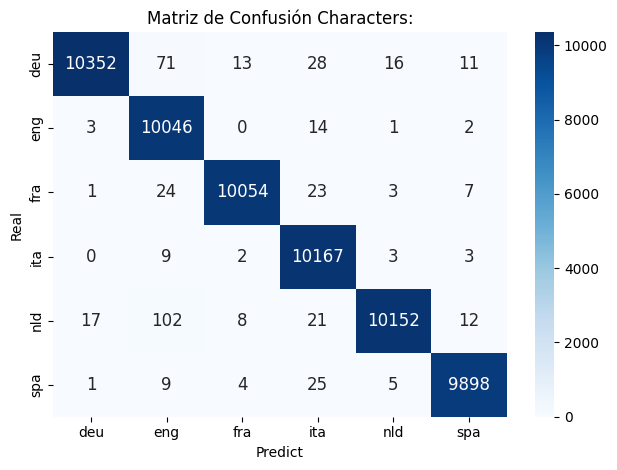

Matriz de Confusión Wrds:
[[ 9791    22     2   668     8     0]
 [   17  9951     1    96     0     1]
 [    2     0 10110     0     0     0]
 [    8     0     0 10175     1     0]
 [   27    13     3   202 10067     0]
 [   26     0     0     1     0  9915]]


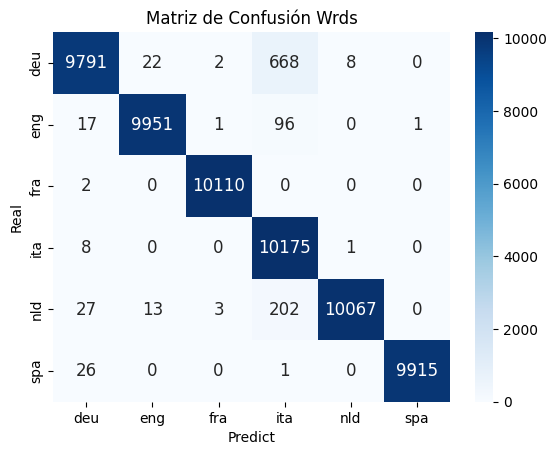

In [45]:
matriu_confusio_chars = sklearn.metrics.confusion_matrix(valor_obj_chars, prediccio_chars)
matriu_confusio_words = sklearn.metrics.confusion_matrix(valor_obj_words, prediccio_words)

labels = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']

print("Matriu de Confusió de Caracters:")
print(matriu_confusio_chars)

### Matriu de confusión de characters
sns.heatmap(matriu_confusio_chars, annot=True, annot_kws={"size": 12}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriz de Confusión Characters:')
plt.tight_layout()
plt.show()


print("Matriz de Confusión Wrds:")
print(matriu_confusio_words)


### Matriu de confusión de wrds
sns.heatmap(matriu_confusio_words, annot=True, annot_kws={"size": 12}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriz de Confusión Wrds')
plt.tight_layout
plt.show()


## Matrices de confusión 'accuracy'
---

Calculamos la 'exactitud' general de las predicciones, tanto para caracteres como para palabras, y construimos sus respectivas matrices de confusión mostrando en este caso el porcentaje de éxito:

- Matriz de confusión con 'exactitud' de los caracteres
- Matriz de confusión con 'exactitud' de las palabras

Accuracy para caracteres:  0.9928322450783053
Accuracy para palabras:  0.9820315184839707

Matriz de confusión de caracteres con accuracy:


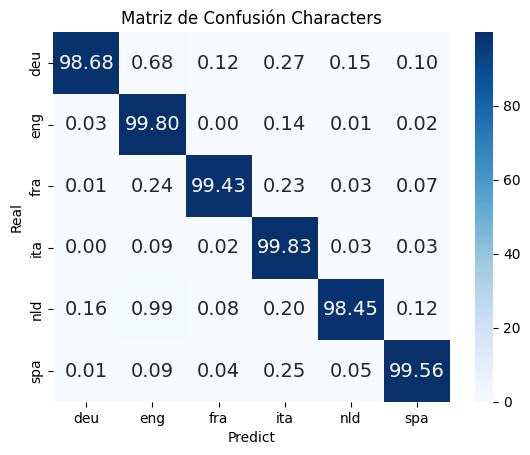


Matriz de confusión de palabras con accuracy:


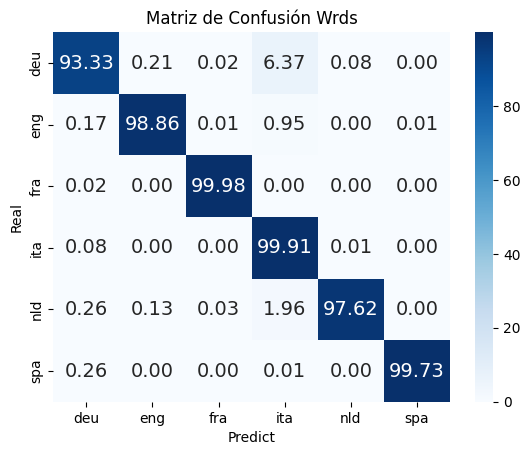

In [46]:

# Calculamos la accuracy
accuracy_chars = sklearn.metrics.accuracy_score(valor_obj_chars, prediccio_chars)
accuracy_words = sklearn.metrics.accuracy_score(valor_obj_words, prediccio_words)
print("Accuracy para caracteres: ", accuracy_chars)
print("Accuracy para palabras: ", accuracy_words)

# Hacemos la matriz de confusión con la accuracy
matriu_confusio_chars = np.round(matriu_confusio_chars / matriu_confusio_chars.sum(axis=1)[:, np.newaxis] * 100, decimals=29)
matriu_confusio_words = np.round(matriu_confusio_words / matriu_confusio_words.sum(axis=1)[:, np.newaxis] * 100, decimals=29)

### Matriz de confusión de caracteres con accuracy
print("\nMatriz de confusión de caracteres con accuracy:")
sns.heatmap(matriu_confusio_chars, annot=True, annot_kws={"size": 14}, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriz de Confusión Characters')
plt.show()


### Matriz de confusión de palabras con accuracy
print("\nMatriz de confusión de palabras con accuracy:")
sns.heatmap(matriu_confusio_words, annot=True, annot_kws={"size": 14}, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriz de Confusión Wrds')
plt.show()

